In [287]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
from scipy import stats

import warnings

# 5 Model Calibration and Mapping

## 5.1 Calibrating model 

We want to calibrate model such that average PD = 6%, and we choose to manipulate an intercept term.

In [288]:
# import features that we will use for further model development
features = pd.read_csv('Final_Features.csv')['Features']

# import the 80% train dataset as training dataset
train_id = pd.read_csv('train80.csv')['SK_ID_CURR']
trainid=train_id.values.tolist()
X_train = pd.read_csv('train80.csv').drop(['TARGET'],axis=1)[features]
y_train = pd.read_csv('train80.csv')[['TARGET']]


In [289]:
# Scale each feature to 0-1
scaler1 = MinMaxScaler(feature_range = (0, 1))
scaler1.fit(X_train)
X_train = scaler1.transform(X_train)

# fit logistic regression model 
# predict PD for 80% training dataset for calibrating model
log_reg = LogisticRegression(C=0.5,class_weight='balanced',random_state=0).fit(X_train, y_train)
log_reg_prob_train = log_reg.predict_proba(X_train)[:, 1]
#average PD for training dataset before calibrating
np.mean(log_reg_prob_train)

/Users/EricaBai/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.4308479817634397

In [290]:
# intercept value before calibrating
log_reg.intercept_

array([-0.0422266])

In [291]:
# other coefficients values in the logistical regression model
log_reg.coef_

array([[-0.90655699, -1.66923641, -0.63657144,  1.93617462,  0.46562482,
        -0.71676845, -1.92915471, -1.10735939, -0.42330581]])

In [266]:
# function for manipulating intercept term by gradient descent algorithm
def get_intersec(prob,alpha = 10,target_pd = 0.06,iteration = 10000,tolerance = 1e-7):
    #update logit with new intercept
    new_lgits = lambda p_lst,offset:[np.log(p/(1-p))+offset for p in p_lst]
    # logit back to numeric probability
    new_probs = lambda p_lst,offset: [1/(1+np.e**(-lgt)) for lgt in new_lgits(p_lst,offset)]
    # set objective function. (Avg PD =6% and reduce the loss (error))
    object_fun = lambda x:(np.mean(x)-target_pd)**2
    
    #initial intercept changes
    pre_inter = 0
    cur_inter = pre_inter +0.001
    # set the sign of the intercept changes by comparing the current objective funtion value with the previous one.
    flag = 1 if object_fun(new_probs(prob,cur_inter)) <= object_fun(new_probs(prob,pre_inter)) else -1
    for i in range(iteration):
        # update new objective function 
        res_obj = object_fun(new_probs(prob,cur_inter))
        if res_obj<tolerance:
            #stop, if the new observation function value is less than tolenrance value.
            return cur_inter
        else:
            #otherwise, update intercept 
            delta = res_obj 
            pre_inter = cur_inter
            cur_inter = pre_inter + delta*alpha*flag*i
            #print(delta)
    return cur_inter
        

In [267]:
# obtain intercept term 
intercept_train = get_intersec(log_reg_prob_train)
intercept_final=pd.DataFrame(columns=['intercept'])
intercept_final['intercept']=[intercept_train]
intercept_final.to_csv('intercept.csv')
intercept_train

-2.754571835299698

So, we have obtained the intercept term value. Then we apply the intercept term to get the new PD of the training dataset.

In [268]:
# calibrate model and obtain new prob
new_lgits = lambda p_lst,offset:[np.log(p/(1-p))+offset for p in p_lst]
new_probs = lambda p_lst,offset: [1/(1+np.e**(-lgt)) for lgt in new_lgits(p_lst,offset)]
new_p_train80=new_probs(log_reg_prob_train,intercept_train)
# mean of PD for 80% train dataset after calibrating
np.mean(new_p_train80)

0.06031575713736845

We have the average PD on training data for around 6%.

In [269]:
# how many different pd values we have
diff_PD=np.ones(60)
for i in range(0,60):
    for j in range(0,60):
        if new_p_train80[j].item()!=new_p_train80[i].item():
            diff_PD[i]=diff_PD[i]+1
diff_PD

array([60., 60., 60., 60., 60., 60., 60., 60., 60., 60., 60., 60., 60.,
       60., 60., 60., 60., 60., 60., 60., 60., 60., 60., 60., 60., 60.,
       60., 60., 60., 60., 60., 60., 60., 60., 60., 60., 60., 60., 60.,
       60., 60., 60., 60., 60., 60., 60., 60., 60., 60., 60., 60., 60.,
       60., 60., 60., 60., 60., 60., 60., 60.])

So, we at least have 50 different PD in final model.

## 5.2 Mapping

Now, we map the PD of training dataset to five classes (A-E) to see each class's concentration.

In [270]:
# Crete a list to map the probabilities (A-E) and create five tables for each class. 
def mapping_credit_class(new_p,trainid):
    mapping=[]
    a=[]
    a_id =[]
    b=[]
    b_id =[]
    c=[]
    c_id =[]
    d=[]
    d_id =[]
    e=[]
    e_id =[]
    target_num =[]
    group_a= dict()
    group_b= dict()
    group_c= dict()
    group_d= dict()
    group_e= dict()
    creditclass=dict()
    for x in range(0,len(new_p)):
        # if PD is 0%-2%, then class A.
        if new_p[x]>=0 and new_p[x]< 0.02:
            mapping.append('A')
            a.append(new_p[x])
            a_id.append(trainid[x])
        # if PD is 2%-6%, then class B.
        elif new_p[x]>=0.02 and new_p[x]<0.06:
            mapping.append('B')
            b.append(new_p[x])
            b_id.append(trainid[x])
        # if PD is 6%-13%, then class C.
        elif new_p[x]>=0.06 and new_p[x]<0.13:
            mapping.append('C')
            c.append(new_p[x])
            c_id.append(trainid[x])
        # if PD is 13%-25%, then class D.
        elif new_p[x]>=0.13 and new_p[x]<0.25:  
            mapping.append('D')
            d.append(new_p[x])
            d_id.append(trainid[x])
        # if PD is 25%-100%, then class E.
        elif new_p[x]>=0.25 and new_p[x]<1:
            mapping.append('E')
            e.append(new_p[x])
            e_id.append(trainid[x])
   
    #table all the class values    
    group_a['SK_ID_CURR'] = a_id
    group_a['Class_of_Default'] = a
    group_a=pd.DataFrame(data= group_a)
    group_b['SK_ID_CURR'] = b_id
    group_b['Class_of_Default'] = b
    group_b=pd.DataFrame(data= group_b)
    group_c['SK_ID_CURR'] = c_id
    group_c['Class_of_Default'] = c
    group_c=pd.DataFrame(data= group_c)
    group_d['SK_ID_CURR'] = d_id
    group_d['Class_of_Default'] = d
    group_d=pd.DataFrame(data= group_d)
    group_e['SK_ID_CURR'] = e_id
    group_e['Class_of_Default'] = e
    group_e=pd.DataFrame(data= group_e)
    creditclass['SK_ID_CURR']=trainid
    creditclass['Class_of_Default']=mapping
    creditclass['Probability_of_Default']=new_p
    creditclass=pd.DataFrame(data= creditclass)
    return(creditclass,group_a,group_b,group_c,group_d,group_e)


In [271]:
# apply the new PD for training dataset after calibrating to the mapping function, then obtain the class for each person.
credit_class_train,classA_train,classB_train,classC_train,classD_train,classE_train=mapping_credit_class(new_p_train80,trainid)

In [272]:
# Print out the class for each person in training dataset with their ID
credit_class_train

SK_ID_CURR Class_of_Default  Probability_of_Default
0          184307                B                0.045910
1          228582                B                0.048511
2          342012                B                0.051611
3          299158                B                0.038774
4          423647                B                0.027119
...           ...              ...                     ...
23195      104174                C                0.122435
23196      278612                A                0.008525
23197      408425                B                0.026254
23198      152969                B                0.046204
23199      219146                B                0.023422

[23200 rows x 3 columns]

In [273]:
# Average Percentage of predicted PD among 80% training dataset
print(np.mean(new_p_train80))

0.06031575713736845


In [274]:
# Percentage of ClassA in training dataset (80% of overall train dataset)
print('Percentage of ClassA',(len(classA_train)/len(credit_class_train))*100,'%')
print('ClassA members')
print(classA_train)
# Percentage of ClassB in training dataset (80% of overall train dataset)
print('Percentage of ClassB',(len(classB_train)/len(credit_class_train))*100,'%')
print('ClassB members')
print(classB_train)
# Percentage of ClassC in training dataset (80% of overall train dataset)
print('Percentage of ClassC',(len(classC_train)/len(credit_class_train))*100,'%')
print('ClassC members')
print(classC_train)
# Percentage of ClassD in training dataset (80% of overall train dataset)
print('Percentage of ClassD',(len(classD_train)/len(credit_class_train))*100,'%')
print('ClassD members')
print(classD_train)
# Percentage of ClassE in training dataset (80% of overall train dataset)
print('Percentage of ClassE',(len(classE_train)/len(credit_class_train))*100,'%')
print('ClassE members')
print(classE_train)

Percentage of ClassA 18.58189655172414 %
ClassA members
      SK_ID_CURR  Class_of_Default
0         377156          0.012228
1         229495          0.006539
2         240659          0.018049
3         267264          0.009568
4         165938          0.017366
...          ...               ...
4306      431789          0.009196
4307      399122          0.011274
4308      319846          0.008704
4309      409246          0.008846
4310      278612          0.008525

[4311 rows x 2 columns]
Percentage of ClassB 45.62931034482759 %
ClassB members
       SK_ID_CURR  Class_of_Default
0          184307          0.045910
1          228582          0.048511
2          342012          0.051611
3          299158          0.038774
4          423647          0.027119
...           ...               ...
10581      125166          0.059815
10582      178594          0.053527
10583      408425          0.026254
10584      152969          0.046204
10585      219146          0.023422

[10586 row

In [275]:
# Organize the concentration for each class in training dataset
class_80training=[len(classA_train)/len(credit_class_train),len(classB_train)/len(credit_class_train),
                  len(classC_train)/len(credit_class_train),len(classD_train)/len(credit_class_train),
                  len(classE_train)/len(credit_class_train)]
class_name=['A','B','C','D','E']
class_training=dict()
class_training['Class']=class_name
class_training['Concentration_of_Training']=class_80training
# Show the concentration of each class in training dataset
pd.DataFrame(data=class_training)

Class  Concentration_of_Training
0     A                   0.185819
1     B                   0.456293
2     C                   0.261724
3     D                   0.084828
4     E                   0.011336

We can observe that after calibrating, the class B has the highest concentration with around 45.63%, and all the classes' concentrations are smaller than 50%. So, the model is good fitted for training dataset.

# 6 Back Testing 

## 6.1 Class Distribution For Back Testing Dataset

We use the calibrated model to predict the PD for the back testing dataset (which from the 20% overall train dataset).

In [276]:
# import 20% train dataset as back testing dataset
train20_id = pd.read_csv('train20.csv')['SK_ID_CURR']
train20id=train20_id.values.tolist()
X_test = pd.read_csv('train20.csv').drop(['TARGET'],axis=1)[features]
y_test = pd.read_csv('train20.csv')[['TARGET']]

# Scale each feature to 0-1
scaler2 = MinMaxScaler(feature_range = (0, 1))
scaler2.fit(X_test)
X_test = scaler2.transform(X_test)

# predict PD for 20% training dataset for back testing
log_reg_prob_test = log_reg.predict_proba(X_test)[:, 1]
# obtain new prob for test data (20% training data) by calibrating
new_p_test20=new_probs(log_reg_prob_test,intercept_train)

In [277]:
# mapping PD of backtesting dataset
credit_class_test20,classA_test20,classB_test20,classC_test20,classD_test20,classE_test20=mapping_credit_class(new_p_test20,train20id)

In [278]:
# Print out the class for each person in backtesting dataset with their ID
credit_class_test20

SK_ID_CURR Class_of_Default  Probability_of_Default
0         409306                B                0.035045
1         159432                A                0.004582
2         169394                C                0.090305
3         190086                B                0.027122
4         274341                B                0.031623
...          ...              ...                     ...
5787      247847                B                0.040133
5788      320471                C                0.068656
5789      373999                A                0.009792
5790      406679                B                0.049854
5791      441754                E                0.278364

[5792 rows x 3 columns]

In [279]:
# Average Percentage of predicted PD among rest 20% train dataset
print('Average Percentage of predicted PD among rest 20% train dataset',np.mean(new_p_test20))


Average Percentage of predicted PD among rest 20% train dataset 0.056291860292245886


In [280]:
# Percentage of ClassA in testing dataset (20% of overall training)
print('Percentage of ClassA',(len(classA_test20)/len(credit_class_test20))*100,'%')
print('ClassA members')
print(classA_test20)
# Percentage of ClassB in testing dataset (20% of overall training)
print('Percentage of ClassB',(len(classB_test20)/len(credit_class_test20))*100,'%')
print('ClassB members')
print(classB_test20)
# Percentage of ClassC in testing dataset (20% of overall training)
print('Percentage of ClassC',(len(classC_test20)/len(credit_class_test20))*100,'%')
print('ClassC members')
print(classC_test20)
# Percentage of ClassD in testing dataset (20% of overall training)
print('Percentage of ClassD',(len(classD_test20)/len(credit_class_test20))*100,'%')
print('ClassD members')
print(classD_test20)
# Percentage of ClassE in testing dataset (20% of overall training)
print('Percentage of ClassE',(len(classE_test20)/len(credit_class_test20))*100,'%')
print('ClassE members')
print(classE_test20)

Percentage of ClassA 22.11671270718232 %
ClassA members
      SK_ID_CURR  Class_of_Default
0         159432          0.004582
1         364400          0.010063
2         441133          0.004693
3         294973          0.003853
4         199529          0.009719
...          ...               ...
1276      248123          0.016328
1277      214035          0.011420
1278      333270          0.009746
1279      178129          0.015998
1280      373999          0.009792

[1281 rows x 2 columns]
Percentage of ClassB 45.545580110497234 %
ClassB members
      SK_ID_CURR  Class_of_Default
0         409306          0.035045
1         190086          0.027122
2         274341          0.031623
3         400673          0.047873
4         341669          0.026740
...          ...               ...
2633      317225          0.022760
2634      130074          0.038670
2635      380117          0.030176
2636      247847          0.040133
2637      406679          0.049854

[2638 rows x 2 column

In [281]:
# how many different PD we obtain in backtesting.
print(len(new_p_test20))
def diff_PD(new_p):    
    diffPD=np.ones(len(new_p))
    for i in range(0,len(new_p)):
        for j in range(0,len(new_p)):
            if new_p[j].item()!=new_p[i].item():
                diffPD[i]=diffPD[i]+1
    return(diffPD)
print(diff_PD(new_p_test20))

5792
[5792. 5792. 5792. ... 5792. 5792. 5792.]


So, we have 5792 different PD values for backtesting dataset.

## 6.2 Maximum Concentration Test

In [282]:
# Organize the concentration for each class in backtesting dataset
class_20test = [len(classA_test20)/len(credit_class_test20),len(classB_test20)/len(credit_class_test20),
                len(classC_test20)/len(credit_class_test20),len(classD_test20)/len(credit_class_test20),
                len(classE_test20)/len(credit_class_test20)]
class_train_backtest=dict()
class_train_backtest['Class']=class_name
class_train_backtest['Concentration_of_Training']=class_80training
class_train_backtest['Concentration_of_BackTesting']=class_20test
# Show the concentration of each class in training dataset
pd.DataFrame(data=class_train_backtest)

Class  Concentration_of_Training  Concentration_of_BackTesting
0     A                   0.185819                      0.221167
1     B                   0.456293                      0.455456
2     C                   0.261724                      0.236533
3     D                   0.084828                      0.077693
4     E                   0.011336                      0.009151

We can see that all the concentration for backtesting dataset in each class is smaller than 50%. For training dataset the highest concentration value is in class B with around 45.63%, and there is no class for backtesting dataset exceeds that highest concentration value (45.63%) . (i.e. 45.55%<45.63%). Therefore, the backtesting dataset passes the test.

## 6.3 Performance Test (KPI)

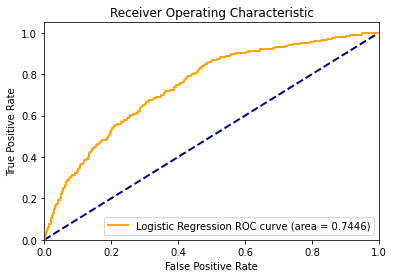

In [283]:
# Compute false positive rate, true positive rate, and AUROC for training set (after calibrating)
fpr_logReg_train, tpr_logReg_train, _ = roc_curve(y_train, new_p_train80)
auroc_logReg_train = roc_auc_score(y_train,new_p_train80)

# compute ks for training set
y_train['PROB']=new_p_train80
prob0_df = y_train[y_train['TARGET']==0][['PROB']]
prob1_df = y_train[y_train['TARGET']==1][['PROB']]
y_train = y_train.drop(['PROB'],axis=1)
ks_logReg_train, pvalue_logReg_train = stats.ks_2samp(prob0_df['PROB'],prob1_df['PROB'])

# Compute false positive rate, true positive rate, and AUROC for testing set
fpr_logReg_test, tpr_logReg_test, _ = roc_curve(y_test, new_p_test20)
auroc_logReg_test = roc_auc_score(y_test,new_p_test20)

# compute ks for testing set
y_test['PROB']=new_p_test20
prob0_df = y_test[y_test['TARGET']==0][['PROB']]
prob1_df = y_test[y_test['TARGET']==1][['PROB']]
y_test = y_test.drop(['PROB'],axis=1)
ks_logReg_test, pvalue_logReg_test = stats.ks_2samp(prob0_df['PROB'],prob1_df['PROB'])


# create a dataframe containing auroc, ks, and absolute difference between training and testing set
auroc_ks_df = pd.DataFrame(columns=['Models','AUROC_train(%)','AUROC_test(%)','KS_train(%)','KS_test(%)','ABS AUROC diff(%)','ABS KS diff(%)'])
auroc_ks_df['Models'] = np.array(['Logistic Regression'])
auroc_ks_df['AUROC_train(%)'] = np.array([round(auroc_logReg_train,4)*100])
auroc_ks_df['AUROC_test(%)'] = np.array([round(auroc_logReg_test,4)*100])
auroc_ks_df['KS_train(%)'] = np.array([round(ks_logReg_train,4)*100])
auroc_ks_df['KS_test(%)'] = np.array([round(ks_logReg_test,4)*100])
auroc_ks_df['ABS AUROC diff(%)'] = round(abs(auroc_ks_df['AUROC_train(%)'] - auroc_ks_df['AUROC_test(%)']),4)
auroc_ks_df['ABS KS diff(%)'] = round(abs(auroc_ks_df['KS_train(%)'] - auroc_ks_df['KS_test(%)']),4)

# plot Receiving Operating Curve (ROC)
plt.figure()
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.plot(fpr_logReg_test, tpr_logReg_test, color='orange',
         lw=2, label='Logistic Regression ROC curve (area = %0.4f)' % auroc_logReg_test)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [284]:
auroc_ks_df

Models  AUROC_train(%)  AUROC_test(%)  KS_train(%)  \
0  Logistic Regression           72.76          74.46        34.93   

   KS_test(%)  ABS AUROC diff(%)  ABS KS diff(%)  
0       36.87                1.7            1.94

We can see that AUROC is greater than 70% for both training and backtesting dataset. KS tests are also greater than 30% for both datasets. The differences between training and backtesting dataset on those two tests are smaller than 5%. Therefore, the backtesting under calibrated model also pass the KPI requirements.  

Therefore, our model can be used to do the further impact analysis.